In [71]:
import pandas as pd
import numpy as np
import sympy as sp
import math as m
from sympy import collect, simplify, expand, fraction, latex, diff, cancel, nsimplify
from IPython.display import display, Markdown, Math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [72]:
class numden_coeff:
    def __init__(self, expr, symb):
        self.num, self.denum = fraction(expr)
        self.symb = symb
        self.common_factor = None
        self.lst_denum_coeff = self.build_lst(self.denum)
        self.lst_num_coeff = self.build_lst(self.num)
        
    def build_lst(self, poly):
        order = sp.Poly(poly, self.symb).degree()
        lst = [expand(poly).coeff(self.symb**i) for i in range((order), 0, -1)]
        lst.append(poly.subs(self.symb,0))
        if (self.common_factor == None):
            self.common_factor = lst[0]
            
        lst = [simplify(lst[i]/self.common_factor) for i in range(order + 1)]
        return lst
    
    def disp(self):
        display(Markdown(r"Numerator coefficients (\beta)"), self.lst_num_coeff)
        display(Markdown(r"Denominator coefficients (alpha)"), self.lst_denum_coeff)

# Problem 1

## Part 1

In [73]:
a, b, p, e = sp.symbols("a b p e")
zeta, omega, gamma_prime, gamma, theta1, theta2 = sp.symbols("zeta omega \\gamma^{'} gamma theta_1 theta_2")
y, u, uc, ym = sp.symbols("y(t) u(t) u_{c}(t) y_m")

y_eq = sp.solve(sp.Eq(y*p**2, (-a*p*y + b*u)), y)[0]

u_eq = sp.solve(sp.Eq(u, (theta1*(y - uc) - theta2*p*y)), u)[0]
y_eq = sp.solve(sp.Eq(y, y_eq.subs(u, u_eq)), y)[0]
display(Math("y = "+latex(y_eq)))

<IPython.core.display.Math object>

The above equation is $y$ in which {{u_eq}} has been subbed in for $u$ 

In [74]:
bm0, am1, am0 = sp.symbols("b_{m0} a_{m1} a_{m0}")

b_m0 = omega**2
a_m1 = 2*zeta*omega
a_m0 = b_m0

# Bm = bm0
# Am = (p**2 + am1*p + bm0)

Bm = omega**2
Am = (p**2 + 2*zeta*omega*p + omega**2)

Gm = Bm/Am
Gm
display(Math("G_{m} = "+latex(Gm)))

<IPython.core.display.Math object>

Next, the assumption that the plant $y$ will follow exactly the reference model $y_m$ is made to derive $\theta_1$ and $\theta_2$. This yeilds

In [75]:
num, den = fraction(y_eq)
num_m, den_m = fraction(Gm*uc)

theta_1 = sp.solve(sp.Eq(num, num_m), theta1)[0]
theta_2 = sp.solve(sp.Eq(den.subs(theta1, theta_1), den_m), theta2)[0]

display(Math("\\theta_1 =\;"+latex(theta_1)))
display(Math("\\theta_2 =\;"+latex(theta_2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Next, the sensistivity of the error to $\theta_1$ and $\theta_2$ was derived. This will be used to derive equations for $\dot{\theta}_1$ and $\dot{\theta}_2$. The sensitivities $\frac{\partial e}{\partial \theta_1}$ and $\frac{\partial e}{\partial \theta_2}$ can be seen below

In [76]:
del_e_theta1 = collect(simplify(diff(y_eq, theta1)), p)
del_e_theta2 = collect(simplify(diff(y_eq, theta2)), p)

display(Math("\\frac{\\partial e}{\\partial \\theta_1} =\;"+latex(del_e_theta1)))
display(Math("\\frac{\\partial e}{\\partial \\theta_2} =\;"+latex(del_e_theta2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

These equations can be further simplified by deriving an equation for $u_c$ in terms of $y_m$. This way, the sensistivitives can be expressed in terms of $y_m$, a variable in which we have an equation. The equation for $u_c$ and the new equations for $\frac{\partial e}{\partial \theta_1}$ and $\frac{\partial e}{\partial \theta_2}$ in terms of $y_m$ can be seen below 

In [77]:
u_c = sp.solve(sp.Eq(ym, Gm*uc), uc)[0]

del_e_theta1_subd = del_e_theta1.subs([(uc,u_c),(theta1, theta_1), (theta2, theta_2)])
del_e_theta2_subd = del_e_theta2.subs([(uc,u_c),(theta1, theta_1), (theta2, theta_2)])

display(Math("u_c =\;"+latex(u_c)))
display(Math("\\frac{\\partial e}{\\partial \\theta_1} =\;"+latex(del_e_theta1_subd)))
display(Math("\\frac{\\partial e}{\\partial \\theta_2} =\;"+latex(del_e_theta2_subd)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Next, equations for $\dot{\theta}_1$ and $\dot{\theta}_2$ were derived using the equation $\dot{\theta} = -\gamma' e \frac{\partial e}{\partial \theta}$, the results of which can be seen below

In [78]:
theta1_dot = -gamma_prime*e*del_e_theta1_subd
theta2_dot = -gamma_prime*e*del_e_theta2_subd

display(Math("\\dot{\\theta}_1 =\;"+latex(theta1_dot)))
display(Math("\\dot{\\theta}_2 =\;"+latex(theta2_dot)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Letting $\gamma = \gamma^{'}b$ gives

In [79]:
theta1_dot_subd = theta1_dot*gamma/(gamma_prime*b)
theta2_dot_subd = theta2_dot*gamma/(gamma_prime*b)

display(Math("\\dot{\\theta}_1 =\;"+latex(theta1_dot_subd)))
display(Math("\\dot{\\theta}_2 =\;"+latex(theta2_dot_subd)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

These equations were develloped into ODEs in which the ODE solver could digest

In [80]:
obj_theta1_dot = numden_coeff(theta1_dot_subd/ym, p)
obj_theta2_dot = numden_coeff(theta2_dot_subd/ym, p)

atheta1 = obj_theta1_dot.lst_denum_coeff[::-1]
btheta1 = obj_theta1_dot.lst_num_coeff[::-1]

atheta2 = obj_theta2_dot.lst_denum_coeff[::-1]
btheta2 = obj_theta2_dot.lst_num_coeff[::-1]

display(Math("\\alpha\\dot{\\theta}_1 =\;"+latex(atheta1)))
display(Math("\\beta\\dot{\\theta}_1 =\;"+latex(btheta1)))

display(Math("\\alpha\\dot{\\theta}_2 =\;"+latex(atheta2)))
display(Math("\\beta\\dot{\\theta}_2 =\;"+latex(btheta2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [81]:
gamma_val = 7.5
omega_val = 1.5
zeta_val = 0.6

ym_d, ym_dd = sp.symbols("\\dot{y}_{m} \\ddot{y}_{m}")
theta1d, theta1dd = sp.symbols("\\dot{\\theta}_{1} \\ddot{\\theta}_{1}") 
theta2d, theta2dd = sp.symbols("\\dot{\\theta}_{2} \\ddot{\\theta}_{2}") 

theta1_ddd = -atheta1[0]*theta1d - atheta1[1]*theta1dd + btheta1[1]*ym_d + btheta1[2]*ym_dd
theta2_ddd = -atheta2[0]*theta2d - atheta2[1]*theta2dd + btheta2[1]*ym_d

theta1_ddd_subd = theta1_ddd.subs([(gamma, gamma_val),(omega,omega_val), (zeta, zeta_val)])
theta2_ddd_subd = theta2_ddd.subs([(gamma, gamma_val),(omega,omega_val), (zeta, zeta_val)])

theta1_ddd_func = sp.lambdify([theta1d, theta1dd, ym_d, ym_dd, e], theta1_ddd_subd)
theta2_ddd_func = sp.lambdify([theta2d, theta2dd, ym_d, e], theta2_ddd_subd)

display(Math("\\dddot{\\theta}_1 =\;"+latex(theta1_ddd)+"\;=\;"+latex(theta1_ddd_subd)))
display(Math("\\dddot{\\theta}_1 =\;"+latex(theta2_ddd)+"\;=\;"+latex(theta2_ddd_subd)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Part 2.1 (MIT)

In [82]:
def ode_solver(y0, t, a, b, omega, zeta, gamma):
    
    ym, ym_dot = y0[0], y0[1]
    y, y_dot = y0[2], y0[3]
    theta1, theta1_dot, theta1_dotdot = y0[4], y0[5], y0[6]
    theta2, theta2_dot, theta2_dotdot = y0[7], y0[8], y0[9]
    u = y0[10]
    u_c_ode = m.sin(m.pi*t/15) >= 0
    
    ym_dotdot = -2*omega*zeta*ym_dot - omega**2*ym + omega**2*u_c_ode
    y_dotdot = -(a + b*theta2)*y_dot + b*theta1*(y - u_c_ode)
    e = y_dot - ym_dot

    theta1_dotdotdot = theta1_ddd_func(theta1_dot, theta1_dotdot, ym_dot, ym_dotdot, e)
    theta2_dotdotdot = theta2_ddd_func(theta2_dot, theta2_dotdot, ym_dot, e)
    
    u = theta1*(y - u_c_ode) - theta2*y_dot
    
    return [ym_dot, ym_dotdot,
            y_dot, y_dotdot,
            theta1_dot, theta1_dotdot, theta1_dotdotdot,
            theta2_dot, theta2_dotdot, theta2_dotdotdot,
            u]

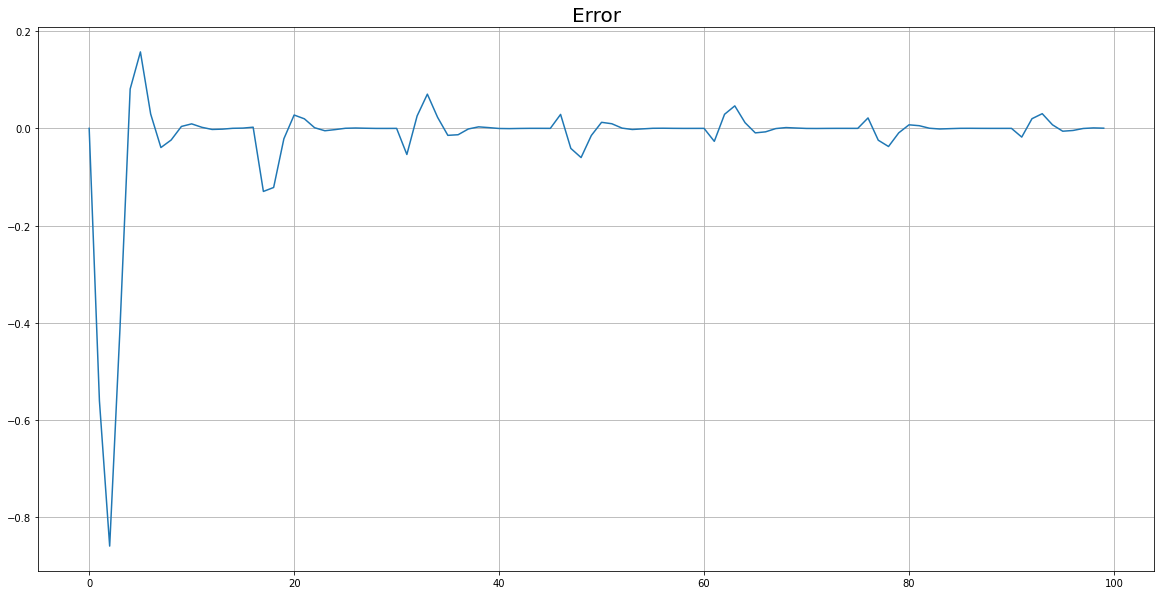

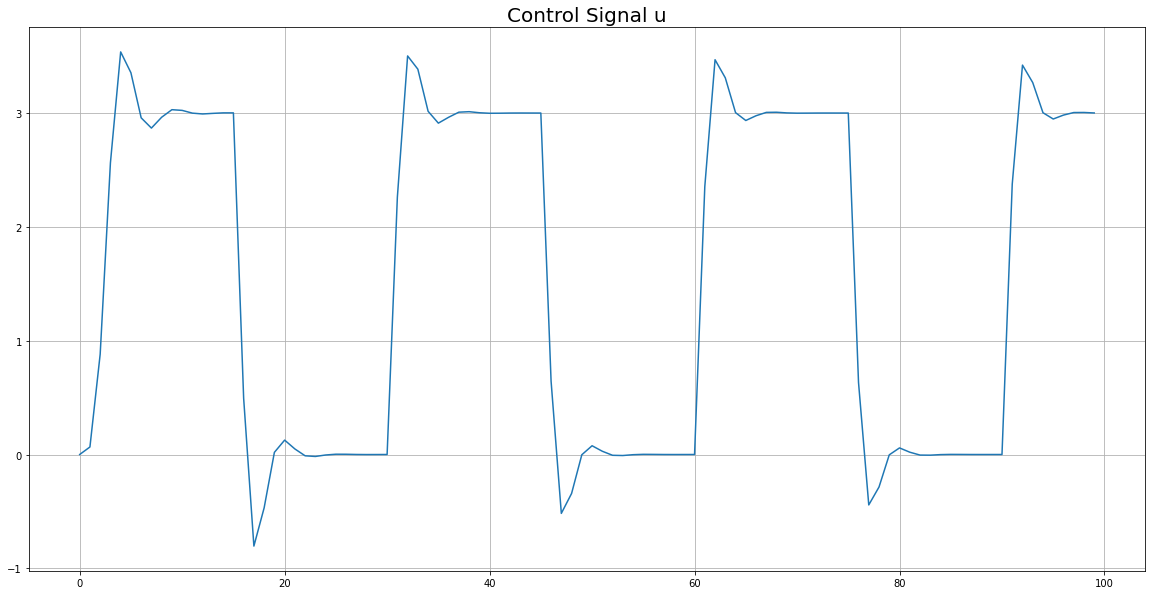

In [83]:
T_val = 0.1
sample_depth = int(10/T_val) # 1000 samples totalling 100 seconds (since sample time T is 0.1 secons)
sample_range = range(sample_depth)
starting_samples = 3

gamma_val = 5
omega_val = 1.5
zeta_val = 0.6
a_val = 3
b_val = 1

# calculation of input signal
t = [i for i in sample_range]
u_c = np.ones(sample_depth)
u_c[np.where([m.sin(t[i]*m.pi*T_val/15)<=0 for i in sample_range])] = 0

y0 = [0]*11

ode_res = odeint(ode_solver, y0, t, args=(a_val, b_val,
                                          omega_val,
                                          zeta_val,
                                          gamma_val))
plt.title("Error", fontsize=20)
plt.plot(t, ode_res[:,2] - ode_res[:,0])
plt.grid()
plt.show()

plt.title("Control Signal u", fontsize=20)
plt.plot(t, ode_res[:,10])
plt.grid()
plt.show()


## Part 2.2 (Normalized MIT)

For the noramlized MIT rule, the equation for theta needed to be updated. The equations derived for $\dot{\theta}_i$ are the  sensistivity equations multiplied by $\gamma e$ therfore, the same procedure for building hte $\dot{\theta}_i$ equations can be reused by simply divinding everything by  $\gamma e$ at the beggining. These new equations will keep the same names as before in the code as to not make many updates to the existing code. the only difference will be setting the actual $\dot{\theta}_i$ equal to $\frac{\gamma \psi \frac{\partial e}{\partial \theta}}{\alpha + \psi^2}$. Additionally, the fact that $\psi = -\frac{\partial e}{\partial \theta}$ will have to be taken into account.

In [84]:
obj_theta1_dot = numden_coeff(theta1_dot_subd/(ym*e*gamma), p)
obj_theta2_dot = numden_coeff(theta2_dot_subd/(ym*e*gamma), p)

atheta1 = obj_theta1_dot.lst_denum_coeff[::-1]
btheta1 = obj_theta1_dot.lst_num_coeff[::-1]

atheta2 = obj_theta2_dot.lst_denum_coeff[::-1]
btheta2 = obj_theta2_dot.lst_num_coeff[::-1]

display(Math("\\alpha \\frac{\\partial e}{\\partial \\theta_1} =\;"+latex(atheta1)))
display(Math("\\beta\\frac{\\partial e}{\\partial \\theta_1} =\;"+latex(btheta1)))

display(Math("\\alpha\\frac{\\partial e}{\\partial \\theta_2} =\;"+latex(atheta2)))
display(Math("\\beta\\frac{\\partial e}{\\partial \\theta_2} =\;"+latex(btheta2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The below equations are named $\theta_i$ simply becasue the code template derived above was reused to minimise the updates needed to the code. These equations are actualy for  $\frac{\partial e}{\partial \theta_i}$

In [85]:
gamma_val = 7.5
omega_val = 1.5
zeta_val = 0.6

ym_d, ym_dd = sp.symbols("\\dot{y}_{m} \\ddot{y}_{m}")
theta1d, theta1dd = sp.symbols("\\dot{\\theta}_{1} \\ddot{\\theta}_{1}") 
theta2d, theta2dd = sp.symbols("\\dot{\\theta}_{2} \\ddot{\\theta}_{2}") 

theta1_ddd = atheta1[0]*theta1d + atheta1[1]*theta1dd + btheta1[1]*ym_d + btheta1[2]*ym_dd
theta2_ddd = atheta2[0]*theta2d + atheta2[1]*theta2dd + btheta2[1]*ym_d

theta1_ddd_subd = theta1_ddd.subs([(gamma, gamma_val),(omega,omega_val), (zeta, zeta_val)])
theta2_ddd_subd = theta2_ddd.subs([(gamma, gamma_val),(omega,omega_val), (zeta, zeta_val)])

theta1_ddd_func = sp.lambdify([theta1d, theta1dd, ym_d, ym_dd], theta1_ddd_subd)
theta2_ddd_func = sp.lambdify([theta2d, theta2dd, ym_d], theta2_ddd_subd)

In [86]:
def ode_solver(y0, t, a, b, omega, zeta, gamma, alpha):
    
    ym, ym_dot = y0[0], y0[1]
    y, y_dot = y0[2], y0[3]
    theta1, theta1_dot, theta1_dotdot = y0[4], y0[5], y0[6]
    theta2, theta2_dot, theta2_dotdot = y0[7], y0[8], y0[9]
    theta1_norm = y0[10]
    theta2_norm = y0[11]
    u = y0[12]
    u_c_ode = m.sin(m.pi*t/15) >= 0
    
    ym_dotdot = -2*omega*zeta*ym_dot - omega**2*ym + omega**2*u_c_ode
    y_dotdot = -(a + b*theta2_norm)*y_dot + b*theta1_norm*(y - u_c_ode)
    e = y_dot - ym_dot

    theta1_dotdotdot = theta1_ddd_func(theta1_dot, theta1_dotdot, ym_dot, ym_dotdot)
    theta2_dotdotdot = theta2_ddd_func(theta2_dot, theta2_dotdot, ym_dot)
    
    theta1_n = theta1*e*gamma/(alpha + (theta1)**2)
    theta2_n = theta2*e*gamma/(alpha + (theta2)**2)
    
    u = theta1_norm*(y - u_c_ode) - theta2_norm*y_dot
    
    return [ym_dot, ym_dotdot,
            y_dot, y_dotdot,
            theta1_dot, theta1_dotdot, theta1_dotdotdot,
            theta2_dot, theta2_dotdot, theta2_dotdotdot,
            theta1_n,
            theta2_n,
            u]

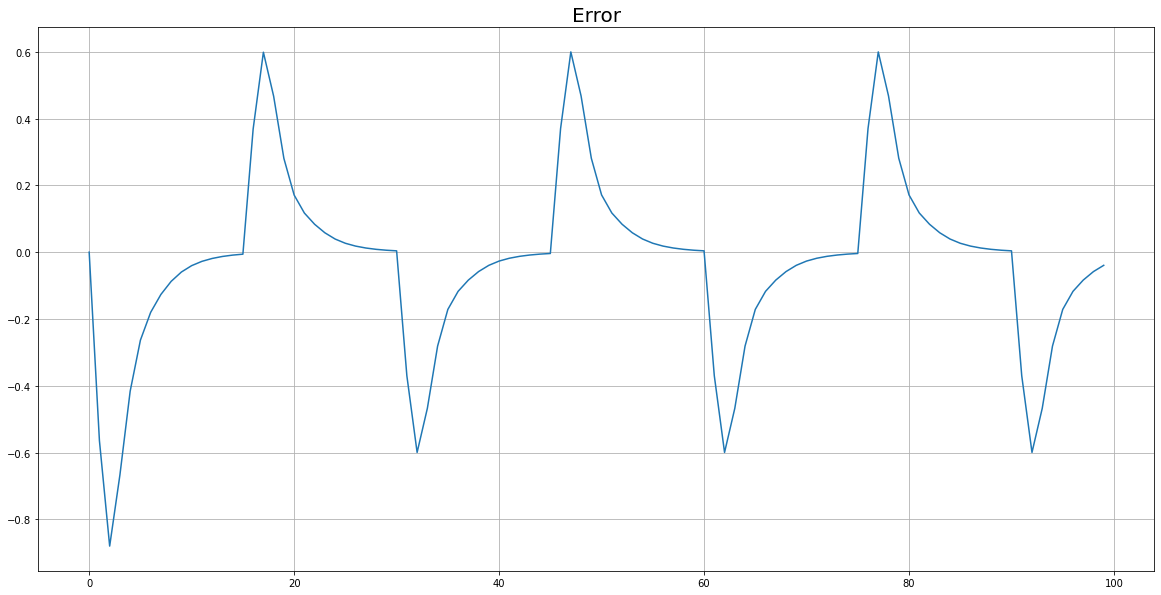

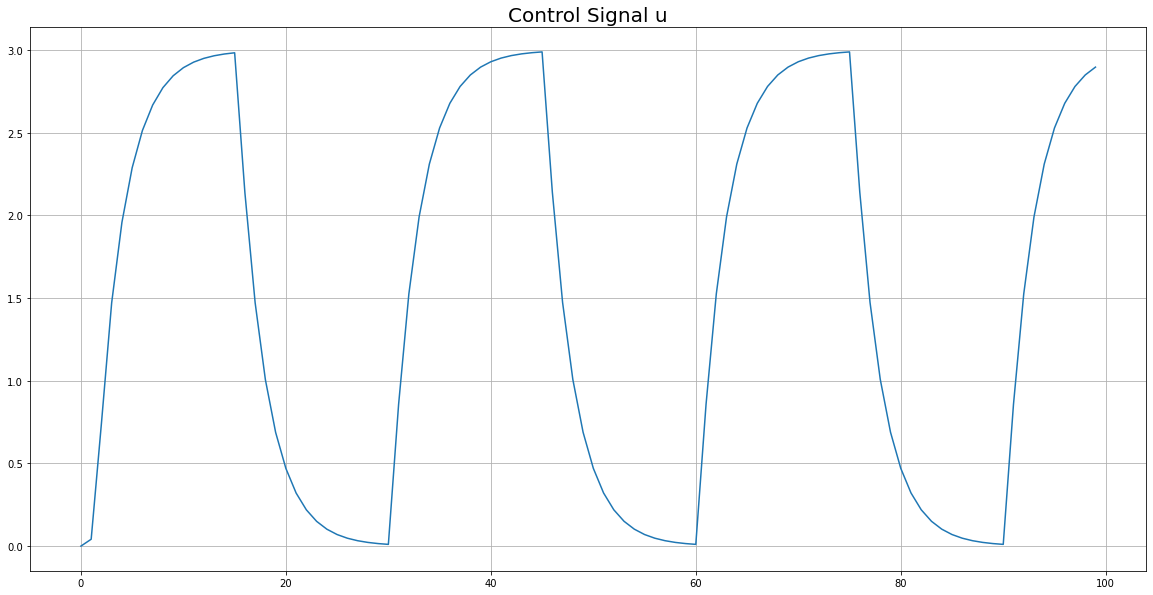

In [87]:
T_val = 0.1
sample_depth = int(10/T_val) # 1000 samples totalling 100 seconds (since sample time T is 0.1 secons)
sample_range = range(sample_depth)
starting_samples = 3

alpha_val = 1
gamma_val = 5
omega_val = 1.5
zeta_val = 0.6
a_val = 3
b_val = 1

# calculation of input signal
t = [i for i in sample_range]
u_c = np.ones(sample_depth)
u_c[np.where([m.sin(t[i]*m.pi*T_val/15)<=0 for i in sample_range])] = 0

y0 = [0]*13

ode_res = odeint(ode_solver, y0, t, args=(a_val, b_val,
                                          omega_val,
                                          zeta_val,
                                          gamma_val,
                                          alpha_val))


plt.title("Error", fontsize=20)
plt.plot(t, ode_res[:,2] - ode_res[:,0])
plt.grid()
plt.show()

plt.title("Control Signal u", fontsize=20)
plt.plot(t, ode_res[:,12])
plt.grid()
plt.show()


# Problem 2

## Part 1

First, an equation for $y$ was derived in terms of $u_c$. This was done by subbing $u = \theta_1 u_c - \theta_2 y$ into $y=\frac{b u}{p}$. This yeilds

In [88]:
y, u, uc, ym, e = sp.symbols("y(t) u(t) u_{c}(t) y_m e")
alpha, beta, gamma, b, theta1, theta2, p = sp.symbols("alpha beta gamma b theta_1 theta_2 p")

V1 = 0.5*e**2
V2 = 1/(b*gamma*2)*(alpha - b*theta2)**2
V3 = 1/(b*gamma*2)*(beta - b*theta1)**2
V = V1 + V2 + V3

y_eq = b*u/p
u_eq = theta1*uc - theta2*y

y_eq = sp.solve(sp.Eq(y,y_eq.subs(u, u_eq)),y)[0]
display(Math("y = "+latex(y_eq)))

<IPython.core.display.Math object>

Next, an equation for $y_m$ was derived from $G_m$. This giave

In [89]:
Bm = beta
Am = p + alpha

Gm = Bm/Am

ym_eq = sp.solve(sp.Eq(ym,Gm*uc), ym)[0]
display(Math("y_{m} = "+latex(ym_eq)))

<IPython.core.display.Math object>

Much like in question 1, the true values in terms of process/model parameters were derived for $\theta_1$ and $\theta_2$. This was done by equating the numerators and denominators of $y$ and $y_m$. This gave

In [90]:
num, den = fraction(y_eq)
num_m, den_m = fraction(ym_eq)

theta_1 = sp.solve(sp.Eq(num, num_m), theta1)[0]
theta_2 = sp.solve(sp.Eq(den, den_m), theta2)[0]

display(Math("\\theta_1 =\;"+latex(theta_1)))
display(Math("\\theta_2 =\;"+latex(theta_2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

A sensitivity equations was derived for $\dot{e}$. This was done with the equation $\dot{e} = \dot{y} - \dot{y}_m$ . The resulting equation was further manipluated by adding and subtracting $\alpha y$ to have an error term ($e$) in the equation

In [91]:
y, u, uc, ym = sp.symbols("y(t) u(t) u_{c}(t) y_m")
alpha, beta, b, theta1, theta2, p = sp.symbols("alpha beta b theta_1 theta_2 p")

y_dot = b*u_eq
ym_dot = -alpha*ym + beta*uc
e_dot = collect(expand(y_dot - ym_dot), y)
e_dot_poly = sp.Poly(e_dot, [y,uc])
e_dot_poly_subd = e_dot_poly.as_expr().subs([(theta1, theta_1), (theta2, theta_2)])

e_dot_alt = uc*(b*theta1 - beta) - b*theta2*y - alpha*e + alpha*y
e_dot_alt_poly = sp.Poly(e_dot_alt, [e, theta1, theta2])


V_subd = V.subs([(e,0), (theta1, theta_1), (theta2, theta_2)])

display(Math("\\dot{y} =\;"+latex(y_dot)))
display(Math("\\dot{y}_m =\;"+latex(ym_dot)))
display(Math("\\dot{e} =\;"+latex(e_dot_poly.as_expr())+"\;=\;"+
            latex(e_dot_alt_poly.as_expr())))
# display(e_dot_alt_poly.coeffs()[3])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Subing in $\theta_1$ and $\theta_2$ into $\dot{e}$ gives $\dot{e}=\;${{e_dot_poly_subd}}. Therefore, if the error is to go to $0$, and $\theta_1$ and $\theta_2$ converge to their true values, then $y$ must converge to $y_m$

Subing these results into the equation provided in the assingment document gives

$V(e) =\;$ {{V}} $\;=\;$ {{V_subd}}

Therefore, the first condition for the lyapunov function is satisfied (i.e. V = 0 at the equilibrium point)

In [92]:
eDot, theta1Dot, theta2Dot = sp.symbols("\\dot{e} \\dot{\\theta}_1 \\dot{\\theta}_2")

V_dot = nsimplify(diff(V1, e))*eDot+ diff(V2,theta2)*theta2Dot + diff(V3,theta1)*theta1Dot
V_dot_subd = V_dot.subs([(eDot, e_dot_alt)])
V_dot_subd_alt = V_dot.subs([(eDot, e_dot_alt), (theta1, theta_1), (theta2, theta_2)])
V_dot_subd_poly = sp.Poly(V_dot_subd, [theta1Dot, theta2Dot, y, uc])

display(Math("\\dot{V}(e) =\;"+latex(V_dot)))
display(Math("\\dot{V}(e) =\;"+latex(V_dot_subd_poly.as_expr())))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Subbing the true values for  $\theta_1$ and $\theta_2$ into $\dot{V}(e)$ gives

$\dot{V}(e)=\;${{V_dot_subd_alt}}

Which means that $\dot{V}(e)$ is decreasing thus satisfying Lyanupov's second criteria. 

## Derivation of Control Parameters

In [93]:
lst_coeffs = V_dot_subd_poly.coeffs()
equ_1 = lst_coeffs[0]*theta1Dot + lst_coeffs[3]*uc
equ_2 = lst_coeffs[1]*theta2Dot + lst_coeffs[2]*y


theta1_dot = sp.solve(sp.Eq(equ_1, 0), theta1Dot)[0]
theta2_dot = sp.solve(sp.Eq(equ_2, 0), theta2Dot)[0]

The equations for updating the control parameters can be obtained from

{{equ_1}}$\;=0$ 

$\Rightarrow \; \dot{\theta}_1 = \;${{theta1_dot}}

and 

{{equ_2}}$\;=0$ 

$\Rightarrow \; \dot{\theta}_2 = \;${{theta2_dot}}

## Part 2

### For $\gamma = 0.2$

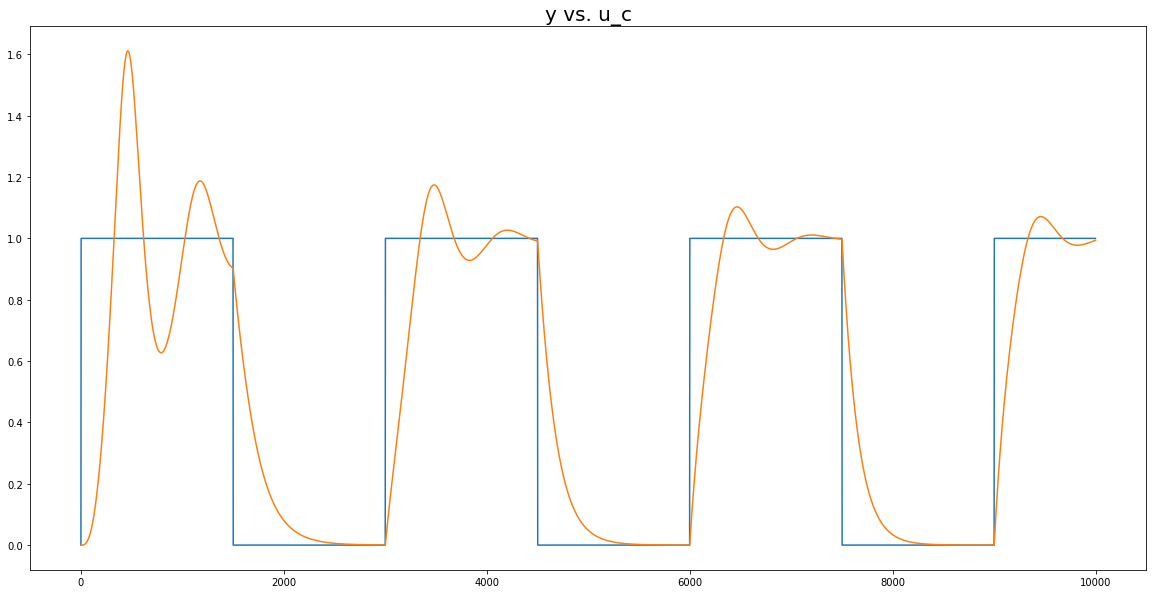

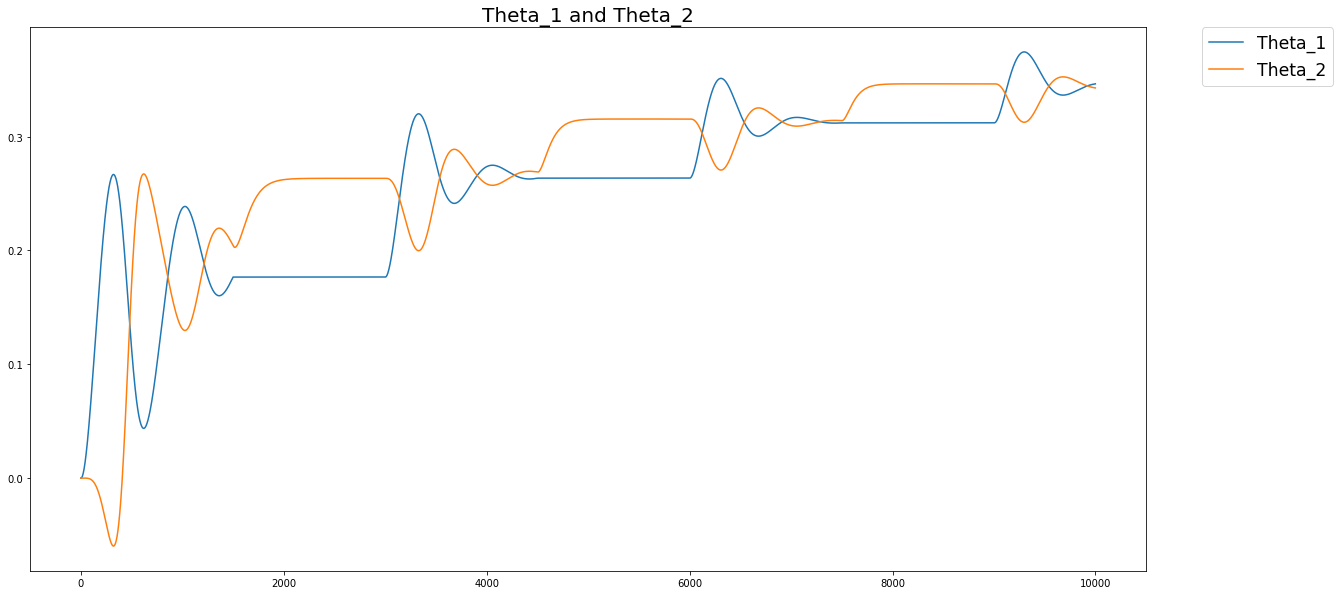

In [94]:
T = 0.01
sample_depth = int(100/T) # 1000 samples totalling 100 seconds (since sample time T is 0.1 secons)
sample_range = range(sample_depth)

t = [i for i in sample_range]
uc = np.ones(sample_depth)
uc[np.where([m.sin(t[i]*m.pi*T/15)<=0 for i in sample_range])] = 0

# actual parameters
b = 2
beta = 1
alpha = 1
gamma = 0.2

y = [0]
ym = [0]
u = [0]
e = 0

theta_1 = [0]
theta_2 = [0]

for i in range(sample_depth):
    theta_1.append(theta_1[i] - T*e*gamma*uc[i])
    theta_2.append(theta_2[i] + T*e*gamma*y[i])
    
    y.append(y[i] + T*b*(theta_1[-1]*uc[i] - theta_2[-1]*y[i]))
    ym.append(ym[i] + T*(-alpha*ym[i] + beta*uc[i]))
    
    e = y[i] - ym[i]
y.pop(-1)
theta_1.pop(-1)
theta_2.pop(-1)

plt.title("y vs. u_c", fontsize=20)
plt.plot(t,uc)
plt.plot(t,y)
plt.show()

plt.title("Theta_1 and Theta_2", fontsize=20)
plt.plot(t, theta_1)
plt.plot(t, theta_2)
plt.legend(bbox_to_anchor=(1.05, 1), 
               loc=2, 
               borderaxespad=0, 
               labels=["Theta_1", "Theta_2"], 
               fontsize='xx-large')
# plt.legend("theta_1", "Theta_2")
    

### For $\gamma = 1$

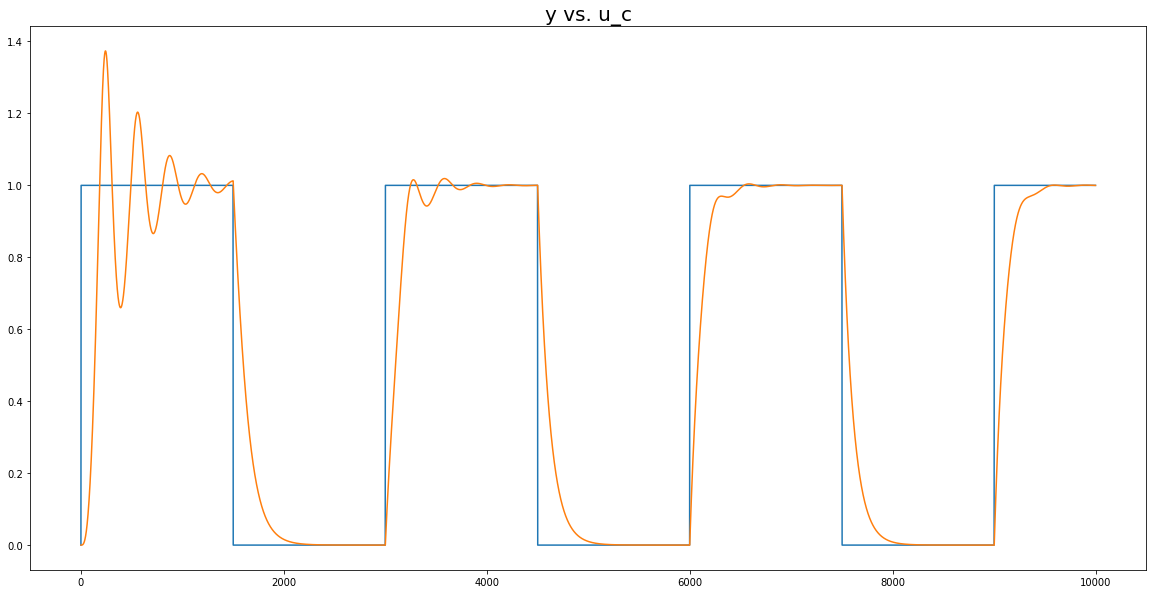

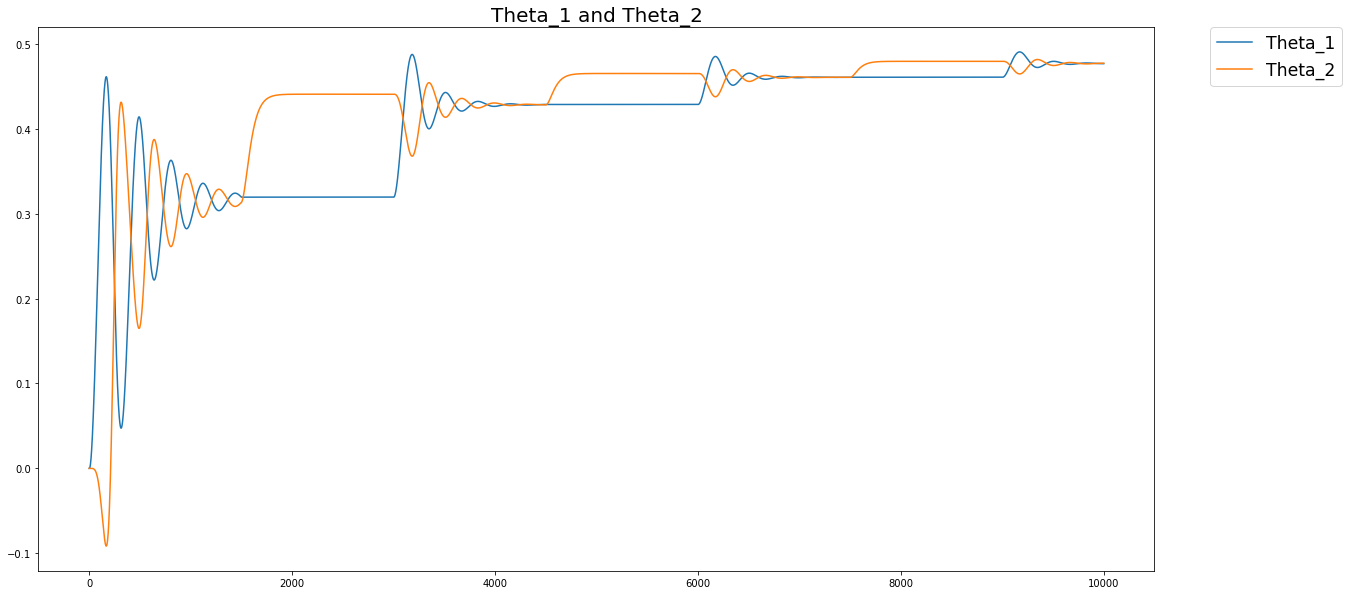

In [95]:
T = 0.01
sample_depth = int(100/T) # 1000 samples totalling 100 seconds (since sample time T is 0.1 secons)
sample_range = range(sample_depth)

t = [i for i in sample_range]
uc = np.ones(sample_depth)
uc[np.where([m.sin(t[i]*m.pi*T/15)<=0 for i in sample_range])] = 0

# actual parameters
b = 2
beta = 1
alpha = 1
gamma = 1

y = [0]
ym = [0]
u = [0]
e = 0

theta_1 = [0]
theta_2 = [0]

for i in range(sample_depth):
    theta_1.append(theta_1[i] - T*e*gamma*uc[i])
    theta_2.append(theta_2[i] + T*e*gamma*y[i])
    
    y.append(y[i] + T*b*(theta_1[-1]*uc[i] - theta_2[-1]*y[i]))
    ym.append(ym[i] + T*(-alpha*ym[i] + beta*uc[i]))
    
    e = y[i] - ym[i]
y.pop(-1)
theta_1.pop(-1)
theta_2.pop(-1)

plt.title("y vs. u_c", fontsize=20)
plt.plot(t,uc)
plt.plot(t,y)
plt.show()

plt.title("Theta_1 and Theta_2", fontsize=20)
plt.plot(t, theta_1)
plt.plot(t, theta_2)
plt.legend(bbox_to_anchor=(1.05, 1), 
               loc=2, 
               borderaxespad=0, 
               labels=["Theta_1", "Theta_2"], 
               fontsize='xx-large')
# plt.legend("theta_1", "Theta_2")
    